In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import re
import os
import glob
from pathlib import Path
import json
from shutil import copyfile
import itertools
from collections import Counter

# analytics
import pandas as pd
import numpy as np

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Spacy Imports
import spacy

from spacy import displacy
from spacy.pipeline import EntityRuler
from spacy.matcher import PhraseMatcher
from spacy.tokens import Doc, Span, Token
from spacy.attrs import intify_attrs

def display_ent(doc):
    displacy.render(doc, style="ent", jupyter=True)

spacy_model = "en_core_web_lg"

nlp = spacy.load(spacy_model)

In [16]:
# User Source Code

import utilsCharlie

In [6]:
# Project Base
base_path = Path('..')

# Data Paths
data_path = base_path / 'data'
all_reports_path = data_path / 'wamex_xml'
subset_reports_path = data_path / 'subset'
test_reports_path = data_path / 'testset'

# Event Path
events_path = base_path / 'events'

# Dictionary Paths
dictionary_path = base_path / 'dictionary'
triggers_path = dictionary_path / 'triggers'
patterns_path = dictionary_path / 'patterns'

# NLP

## Load Match Pattern Pipelines

In [7]:
patterns = []
for filename in patterns_path.iterdir():
    with open(filename, encoding="utf8") as f:
        patterns += json.load(f)
        
print(f'loaded {len(patterns)} patterns')

loaded 31120 patterns


In [8]:
patterns[:5]

[{'label': 'ROCK',
  'pattern': [{'LOWER': 'acapulcoite'}, {'LOWER': 'meteorite'}]},
 {'label': 'ROCK', 'pattern': [{'LOWER': 'aceite'}]},
 {'label': 'ROCK',
  'pattern': [{'LOWER': 'acid'}, {'LOWER': 'volcanic'}, {'LOWER': 'rock'}]},
 {'label': 'ROCK', 'pattern': [{'LOWER': 'adakite'}]},
 {'label': 'ROCK', 'pattern': [{'LOWER': 'adamellite'}]}]

## Add patterns to nlp

In [9]:
ruler = EntityRuler(nlp, overwrite_ents=True)
ruler.add_patterns(patterns)

nlp.add_pipe(ruler)

# Load Trigger Phrases/Words into Spacy PhraseMatcher


In [11]:
triggerPhrase = dictionary_path / 'trigger phrases'
near_miss_phrases =[]

for filename in triggerPhrase.iterdir():
    with open(filename, 'r') as f:
        for line in f:
            if len(line) > 1:
                near_miss_phrases.append(line[:-2].split())

In [12]:
near_miss_phrases

[['weak', 'intercepts'],
 ['minor', 'intercepts'],
 ['weak', 'minor', 'intercepts'],
 ['weak', 'level', 'mineralisation'],
 ['minor', 'level', 'mineralisation'],
 ['mineralisation'],
 ['low', 'level', 'mineralisation'],
 ['weak', 'level', 'mineralization'],
 ['minor', 'level', 'mineralization'],
 ['low', 'level', 'mineralization'],
 ['minor', 'gold'],
 ['minor', 'nickel'],
 ['further', 'drilling', 'required'],
 ['follow', 'up', 'work', 'required'],
 ['further', 'drilling'],
 ['follow', 'up', 'work'],
 ['enrichement'],
 ['enriched'],
 ['subeconomic'],
 ['patchy'],
 ['open', 'at', 'depth'],
 ['open', 'at', 'depth', 'strike'],
 ['open', 'along', 'strike'],
 ['open', 'along'],
 ['extensive'],
 ['promising'],
 ['encouraging'],
 ['auspicious'],
 ['bright'],
 ['gifted'],
 ['talented'],
 ['up-and-coming'],
 ['assuring'],
 ['reassuring'],
 ['rising'],
 ['favourable'],
 ['broad'],
 ['low', 'grade'],
 ['low-grade'],
 ['lowgrade'],
 ['medium', 'grade'],
 ['medium-grade'],
 ['mediumgrade'],
 ['pote

## Geology ent's to extract

In [14]:
geology_ents = ['ORE_DEPOSIT', 'ROCK', 'MINERAL', 'STRAT', 'LOCATION', 'TIMESCALE']

# Event Extraction

In [22]:
from utilsCharlie import create_event_df

eventdf = create_event_df(
    nlp = nlp, 
    directory = subset_reports_path, 
    trigger_phrases = near_miss_phrases, 
    geology_ents = geology_ents,
    n_sentences_extract = 2,
)

100%|██████████| 100/100 [07:32<00:00,  4.53s/it]

found 530 events from a total of 7956 sentences


In [21]:
eventdf.head()

,event_id,filename,sentence_idx,sentence_text,n_trigger_words,trigger_words_in_sentence,trigger_words_in_event,event_text,STRAT,event_label,ROCK,LOCATION,MINERAL,ORE_DEPOSIT,TIMESCALE
0,a080918_e9_1443_annual_09_13904956_0,a080918_e9_1443_annual_09_13904956.json,0,following the completion of the hole and loggi...,1,[potential],[potential],following the completion of the hole and loggi...,dirk hartog formation,0,NaN,NaN,NaN,NaN,NaN
1,a080918_e9_1443_annual_09_13904956_15,a080918_e9_1443_annual_09_13904956.json,15,photos of core c: yaringa e9_1443_annual_09.do...,1,[mineralisation],[mineralisation],mineral drillholes data 2. lithology summary a...,NaN,0,evaporite,"carnarvon basin, australia",NaN,NaN,NaN
2,a080918_e9_1443_annual_09_13904956_18,a080918_e9_1443_annual_09_13904956.json,18,introduction the company has identified the on...,1,[mineralisation],[mineralisation],several suitable target areas were identified ...,NaN,0,sediments,"gascoyne, carnarvon basin",diamond,NaN,NaN
3,a080918_e9_1443_annual_09_13904956_21,a080918_e9_1443_annual_09_13904956.json,21,parts of the adjacent coolcalalaya rift are al...,1,[mineralisation],"[mineralisation, possible]",the gascoyne platform is a diamond shaped area...,NaN,0,"evaporite, sediments","gascoyne, perth",diamond,NaN,NaN
4,a080918_e9_1443_annual_09_13904956_34,a080918_e9_1443_annual_09_13904956.json,34,"a recent detailed analysis of drilling, seismi...",1,[mineralisation],[mineralisation],bromine levels in the halite are high (up to 3...,dirk hartog formation,0,evaporite,NaN,"halite, sylvite, salts",NaN,NaN


## Save Events to csv file

In [60]:
## Make Sure you are saving to your allocated group number

event_path = events_path / 'group_6_events.csv'
eventdf.to_csv(event_path, index=False)

# Visualisations

## Frequency of number of trigger words found in each event

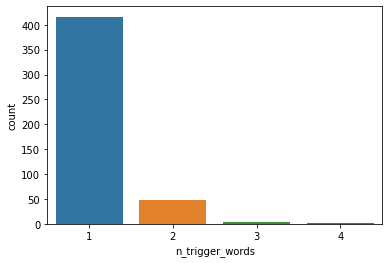

In [63]:
sns.countplot(eventdf.n_trigger_words);

## Count of each trigger word found

In [61]:
from utils import get_feature_counts_df

In [64]:
feature = 'trigger_words_in_sentence'
get_feature_counts_df(eventdf, feature)

,count
trigger_words_in_sentence,
mineralisation,196
potential,124
possible,63
extensive,53
broad,40
low grade,13
favourable,9
encouraging,8
further drilling,8


In [65]:
feature = 'ORE_DEPOSIT'
get_feature_counts_df(eventdf, feature)

,count
ORE_DEPOSIT,
uranium,109
iron ore,18
base metal,14
lode,13
cid,12
gold deposits,12
pge,10
base metals,9
gold deposit,8


In [66]:
feature = 'STRAT'
get_feature_counts_df(eventdf, feature)

,count
STRAT,
greenstone belt,36
fortescue group,11
jeerinah formation,8
coolbro sandstone,8
penneshaw formation,7
...,...
burra monzogranite,1
silt dam monzogranite,1
deep river,1


In [67]:
feature = 'TIMESCALE'
get_feature_counts_df(eventdf, feature)

,count
TIMESCALE,
archaean,44
proterozoic,24
tertiary,20
eocene,13
quaternary,7
archean,7
permian,7
cretaceous,6
mesoproterozoic,5


In [68]:
feature = 'LOCATION'
get_feature_counts_df(eventdf, feature)

,count
LOCATION,
western australia,64
australia,42
norseman,41
gladstone,24
collie,20
...,...
mawson,1
maggie hays,1
jimberlana dyke,1


# Ent Test

In [71]:
example = nlp(eventdf.iloc[2]['event_text'])
display_ent(example)

In [72]:
for ent in example.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

australian 13 23 NORP
gold 24 28 MINERAL
agi 50 53 ORG
sydney 58 64 GPE
gold 136 140 MINERAL
australia 141 150 LOCATION
kga 160 163 ORG
august 1st 2005 168 183 DATE
436 hectares 227 239 QUANTITY
1 247 248 CARDINAL
about 8 kilometres 261 279 QUANTITY
norseman 293 301 LOCATION
about 25 kilometres 307 326 QUANTITY
mt 340 342 GPE
two 360 363 CARDINAL
gladstone 374 383 LOCATION
two 447 450 CARDINAL
croesus mining nl 542 559 ORG
crs 561 564 ORG
croesus 567 574 PERSON
gladstone 651 660 LOCATION
crs 703 706 ORG
annual 707 713 DATE
daisy 286kt 729 740 PERSON
2003 768 772 DATE
gladstone 775 784 LOCATION
2004 818 822 DATE
gladstone 829 838 LOCATION
penneshaw formation 924 943 STRAT
banded iron formation 1003 1024 ROCK
bif 1026 1029 ROCK
noganyer formation 1038 1056 STRAT
kinross 1085 1092 GPE
norseman 1128 1136 LOCATION
gold 1137 1141 MINERAL
woolyeenyer formation 1221 1242 STRAT


In [27]:
minerals = [ent.text for ent in example.ents if ent.label_ == 'MINERAL']
minerals

[]